# Projet Accidents corporels de la circulation routière

## Auteur : Nicolas Lejay

## Juin 2023

***
### A propos
- Ce projet est réalisé à partir de fichiers regroupant les informations sur les accidents corporels de la circulation routière entre 2005 et 2021. L'Observatoire National Interministérielle de la Sécurité Routière fournit quatre fichiers par année : sur les caractéristiques de l'accident, sur le lieu, sur les véhicules impliqués et enfin sur les personnes impliquées. Ici, nous utiliserons quatres fichiers qui sont la compilations de l'ensemble des années. Ces fichiers ont également été nettoyés.
- Pour toute information sur le jeu de données, la signification des variablmes ainsi que sur la définition donnée à « accident corporel de la circulation routière », se repporter au fichier README.md et à la notice de l'ONISR fournis dans le repository : https://github.com/nlejay/accidents_circulation

***
# 1. Importation des fichiers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

# Changement de police des graphiques
plt.rc('font', family = 'serif', serif = 'cmr10')
plt.rcParams.update({"text.usetex": True, "axes.formatter.use_mathtext" : True})

In [2]:
df_caract = pd.read_csv('src/caracteristiques_net_19_06_23.csv',
                        index_col=0,
                        # colonnes avec plusieurs types de formats converties au format str
                        dtype={'hrmn': 'str', 'com' : 'str', 'lat':'str', 'long':'str', 'dep':'str', 'gps':'str'})

df_lieux = pd.read_csv('src/lieux_net_19_06_23.csv',
                        index_col=0,
                        # colonnes avec plusieurs types de formats converties au format str
                        dtype={'voie': 'str', 'pr' : 'str', 'pr1':'str', 'larrout':'str', 'lartpc':'str'})

df_usagers = pd.read_csv('src/usagers_net_19_06_23.csv',
                         index_col=0,
                         # colonnes avec plusieurs types de formats converties au format str
                         dtype={'actp':'str', 'id_vehicule':'str'})
                         
df_veh = pd.read_csv('src/vehicules_net_19_06_23.csv',
                     index_col=0,
                     # colonnes avec plusieurs types de formats converties au format str
                     dtype={'id_vehicule':'str'})

**Dataframe *df_caract***

In [3]:
df_caract.head()

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long
0,201900000001,30,11,2019,01:30,4.0,93,93053,1,1.0,1.0,2.0,AUTOROUTE A3,48.8962100,2.4701200
1,201900000002,30,11,2019,02:50,3.0,93,93066,1,1.0,1.0,6.0,AUTOROUTE A1,48.9307000,2.3688000
2,201900000003,28,11,2019,15:15,1.0,92,92036,1,1.0,1.0,4.0,AUTOROUTE A86,48.9358718,2.3191744
3,201900000004,30,11,2019,20:20,5.0,94,94069,1,1.0,1.0,4.0,A4,48.8173295,2.4281502
4,201900000005,30,11,2019,04:00,3.0,94,94028,1,1.0,1.0,2.0,A86 INT,48.7763620,2.4332540


In [4]:
df_caract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1121571 entries, 0 to 1121570
Data columns (total 15 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   Num_Acc  1121571 non-null  int64  
 1   jour     1121571 non-null  int64  
 2   mois     1121571 non-null  int64  
 3   an       1121571 non-null  int64  
 4   hrmn     1121571 non-null  object 
 5   lum      1121566 non-null  float64
 6   dep      1121571 non-null  object 
 7   com      1121569 non-null  object 
 8   agg      1121571 non-null  int64  
 9   int      1121463 non-null  float64
 10  atm      1121477 non-null  float64
 11  col      1120015 non-null  float64
 12  adr      978295 non-null   object 
 13  lat      634503 non-null   object 
 14  long     634499 non-null   object 
dtypes: float64(4), int64(5), object(6)
memory usage: 136.9+ MB


**Dataframe *df_lieux***

In [5]:
df_lieux.head()

,Num_Acc,catr,voie,v1,v2,circ,nbv,vosp,prof,pr,pr1,plan,lartpc,larrout,surf,infra,situ,vma
0,201900000001,1.0,3,0.0,NaN,3.0,10.0,0.0,1.0,6,900,2.0,NaN,NaN,1.0,2.0,1.0,70.0
1,201900000002,1.0,1,0.0,NaN,1.0,2.0,0.0,4.0,3,845,2.0,NaN,NaN,1.0,0.0,1.0,70.0
2,201900000003,1.0,86,0.0,NaN,3.0,8.0,0.0,1.0,10,500,3.0,NaN,NaN,1.0,0.0,1.0,90.0
3,201900000004,1.0,4,0.0,NaN,3.0,5.0,0.0,1.0,2,299,1.0,NaN,NaN,1.0,0.0,1.0,90.0
4,201900000005,1.0,86,0.0,INT,1.0,3.0,0.0,1.0,41,0,3.0,NaN,NaN,1.0,2.0,1.0,90.0


In [6]:
df_lieux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1121571 entries, 0 to 1121570
Data columns (total 18 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   Num_Acc  1121571 non-null  int64  
 1   catr     1121570 non-null  float64
 2   voie     1014391 non-null  object 
 3   v1       485747 non-null   float64
 4   v2       51369 non-null    object 
 5   circ     1110973 non-null  float64
 6   nbv      1118840 non-null  float64
 7   vosp     1117652 non-null  float64
 8   prof     1119591 non-null  float64
 9   pr       646087 non-null   object 
 10  pr1      644268 non-null   object 
 11  plan     1119259 non-null  float64
 12  lartpc   902739 non-null   object 
 13  larrout  902739 non-null   object 
 14  surf     1090453 non-null  float64
 15  infra    1116163 non-null  float64
 16  situ     1116466 non-null  float64
 17  vma      163102 non-null   float64
dtypes: float64(11), int64(1), object(6)
memory usage: 162.6+ MB


**dataframe *df_usagers***

In [7]:
df_usagers.head()

,Num_Acc,place,catu,grav,sexe,trajet,locp,actp,etatp,an_nais,num_veh,id_vehicule,secu1,secu2,secu3
0,200500000001,1.0,1.0,4.0,1.0,1.0,0.0,0,NaN,1976.0,A01,NaN,1.0,NaN,NaN
1,200500000001,1.0,1.0,3.0,2.0,3.0,0.0,0,NaN,1968.0,B02,NaN,1.0,NaN,NaN
2,200500000001,2.0,2.0,1.0,1.0,0.0,0.0,0,NaN,1964.0,B02,NaN,1.0,NaN,NaN
3,200500000001,4.0,2.0,1.0,1.0,0.0,0.0,0,NaN,2004.0,B02,NaN,3.0,NaN,NaN
4,200500000001,5.0,2.0,1.0,1.0,0.0,0.0,0,NaN,1998.0,B02,NaN,1.0,NaN,NaN


In [8]:
df_usagers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2506762 entries, 0 to 2509619
Data columns (total 15 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Num_Acc      int64  
 1   place        float64
 2   catu         float64
 3   grav         float64
 4   sexe         float64
 5   trajet       float64
 6   locp         float64
 7   actp         object 
 8   etatp        float64
 9   an_nais      float64
 10  num_veh      object 
 11  id_vehicule  object 
 12  secu1        float64
 13  secu2        float64
 14  secu3        float64
dtypes: float64(11), int64(1), object(3)
memory usage: 306.0+ MB


On remarque plus d'observations que dans les deux dataframes précédents. C'est normal : un accident peut impliquer une ou plusieurs personnes.

**Dataframe *df_veh***

In [9]:
df_veh.head()

,Num_Acc,id_vehicule,num_veh,senc,catv,obs,obsm,choc,manv,motor,occutc
0,201900000001,138 306 524,B01,2.0,7.0,0.0,2.0,5.0,23.0,1.0,NaN
1,201900000001,138 306 525,A01,2.0,17.0,1.0,0.0,3.0,11.0,1.0,NaN
2,201900000002,138 306 523,A01,1.0,7.0,4.0,0.0,1.0,0.0,1.0,NaN
3,201900000003,138 306 520,A01,1.0,7.0,0.0,2.0,1.0,2.0,1.0,NaN
4,201900000003,138 306 521,B01,1.0,7.0,1.0,0.0,4.0,2.0,1.0,NaN


In [10]:
df_veh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1914902 entries, 0 to 1914901
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Num_Acc      int64  
 1   id_vehicule  object 
 2   num_veh      object 
 3   senc         float64
 4   catv         float64
 5   obs          float64
 6   obsm         float64
 7   choc         float64
 8   manv         float64
 9   motor        float64
 10  occutc       float64
dtypes: float64(8), int64(1), object(2)
memory usage: 175.3+ MB


Là-aussi, un accident implique souvent plusieurs véhicules. Nous avons donc plus de lignes dans ce dataframe que dans celui sur les accidents.

***
# 2.Étude temporelle
## 2.1. Évolution du nombre d'accidents, de morts et de blessés chaque année
### 2.1.1. Évolution du nombre et variation en pourcentage

1 121 571 accidents répertoriés sur 17 ans, soit une moyenne de 65975 par an. Mais comment a évolué le nombre d'accidents corporels sur la période 2005-2017 ? Et comment ont évolué le nombre de morts et de blessés ?

In [11]:
# Calcul du nombre d'accidents par an
acc_par_an = (df_caract
              .groupby('an')
              .agg(Effectif = pd.NamedAgg('Num_Acc','count'))
              .reset_index())

#Calcul de la variation annuelle
acc_par_an['var_pourc'] = acc_par_an['Effectif'].pct_change() * 100

acc_par_an.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
an,2005.0,2006.000000,2007.000000,2008.000000,2009.000000,2010.000000,2011.000000,2012.000000,2013.000000,2014.000000,2015.000000,2016.000000,2017.000000,2018.00000,2019.000000,2020.00000,2021.000000
Effectif,87026.0,82993.000000,83850.000000,76767.000000,74409.000000,69379.000000,66974.000000,62250.000000,58397.000000,59854.000000,58654.000000,59432.000000,60701.000000,57783.00000,58840.000000,47744.00000,56518.000000
var_pourc,NaN,-4.634247,1.032617,-8.447227,-3.071632,-6.759935,-3.466467,-7.053483,-6.189558,2.494991,-2.004879,1.326423,2.135213,-4.80717,1.829258,-18.85792,18.377178


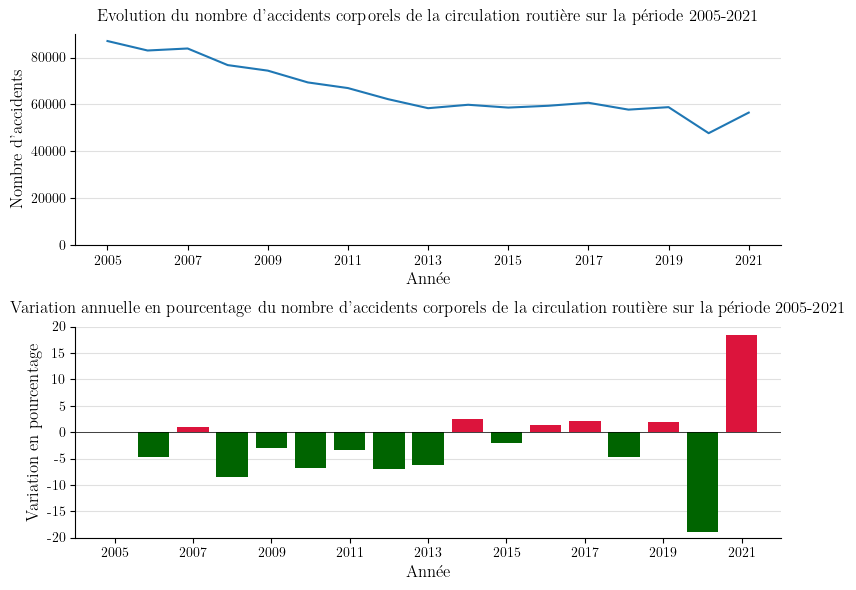

In [12]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.plot(acc_par_an['an'], acc_par_an['Effectif'], color="tab:blue")
ax1.set_ylim(0,90000)
ax1.set_xticks([i for i in range(2005,2022,2)], [i for i in range(2005,2022,2)])
ax1.set_xlabel('Année', size=12)
ax1.set_ylabel("Nombre d'accidents", size=12)
ax1.set_title("Evolution du nombre d'accidents corporels de la circulation routière sur la période 2005-2021", size=12, y=1.02)
ax1.grid(visible=True, axis='y', color="#e0e0e0")


couleurs = ["crimson" if acc_par_an.iloc[i,2]>0 else "darkgreen" for i in range(len(acc_par_an))]
ax2.bar(acc_par_an['an'], acc_par_an['var_pourc'], color=couleurs)
ax2.set_xlabel('Année', size=12)
ax2.set_xlim(2004,2022)
ax2.set_ylabel("Variation en pourcentage", size=12)
ax2.set_ylim(-20,20)
ax2.set_xticks([i for i in range(2005,2022,2)], [i for i in range(2005,2022,2)])
ax2.set_yticks([i for i in range(-20,25,5)], [i for i in range(-20,25,5)])
ax2.grid(visible=True, axis='y', color="#e0e0e0")
ax2.set_title("Variation annuelle en pourcentage du nombre d'accidents corporels de la circulation routière sur la période 2005-2021", size=12, y=1.02)
ax2.set_axisbelow(True)
ax2.hlines(0,2004,2022, color='black', linewidth=0.5)

sns.despine()
plt.tight_layout()
plt.show()

On observe une baisse de 2005 à 2013 puis une stabilisation autour de 60 000 accidents par an. Pour l'année 2020, la chute est sûrement due aux confinents pendant l'épidémie de COVID-19. On remarque d'ailleurs une hausse en 2021 qui ramène quasiment au niveau pré-2020.

Concentrons-nous maintenant sur le nombre de morts et de blessés. Pour cela, une jointure entre *df_caract* et *df_usagers* est nécessaire cr l'année n'est renseignée que dans *df_caract*.

In [13]:
# Calcul du nombre de morts et blessés de chaque type chaque année
gravite_par_an = (df_usagers[['Num_Acc','grav']]
                  .merge(df_caract[['Num_Acc', 'an']], how='inner', left_on='Num_Acc', right_on='Num_Acc')
                  .pivot_table(index='an', columns='grav', values='Num_Acc', aggfunc='count')
                  .rename(columns={1:'Indemne',
                                    2:'Tué',
                                    3:'Hospitalisé',
                                    4:'Bléssé léger'})
                 )

gravite_par_an.transpose().head()

an,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
grav,,,,,,,,,,,,,,,,,
Indemne,80124,76027,76757,69468,67664,62737,60519,56491,52599,53416,53353,54514,56178,54126,55271,43229,55108
Tué,5543,4940,4836,4440,4440,4172,4109,3842,3426,3554,3608,3652,3599,3392,3497,2780,3219
Hospitalisé,40760,41803,39720,36121,34484,31306,30616,28088,26875,27491,27696,28352,28977,22162,20852,16772,19085
Bléssé léger,70760,64045,66873,60651,59139,55782,53183,50057,45688,47597,45628,46697,47124,50300,53256,42451,51681


In [14]:
# Calcul de la variation annuelle en pourcentage
var_gravite_par_an = round(gravite_par_an.pct_change()*100, 1)
var_gravite_par_an.transpose()

an,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
grav,,,,,,,,,,,,,,,,,
Indemne,NaN,-5.1,1.0,-9.5,-2.6,-7.3,-3.5,-6.7,-6.9,1.6,-0.1,2.2,3.1,-3.7,2.1,-21.8,27.5
Tué,NaN,-10.9,-2.1,-8.2,0.0,-6.0,-1.5,-6.5,-10.8,3.7,1.5,1.2,-1.5,-5.8,3.1,-20.5,15.8
Hospitalisé,NaN,2.6,-5.0,-9.1,-4.5,-9.2,-2.2,-8.3,-4.3,2.3,0.7,2.4,2.2,-23.5,-5.9,-19.6,13.8
Bléssé léger,NaN,-9.5,4.4,-9.3,-2.5,-5.7,-4.7,-5.9,-8.7,4.2,-4.1,2.3,0.9,6.7,5.9,-20.3,21.7


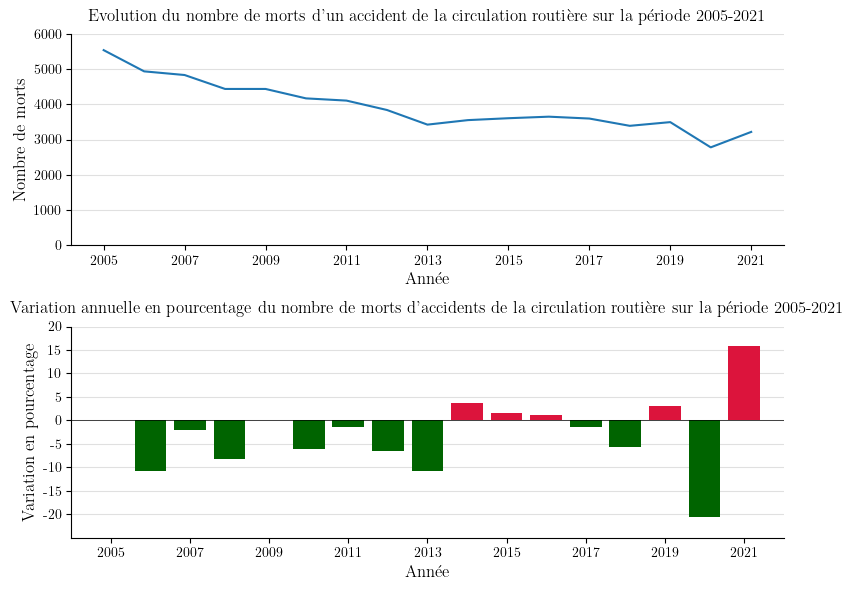

In [15]:
grav_par_an_long = gravite_par_an.unstack().reset_index().rename(columns={0:'Effectif'})
morts_par_an = grav_par_an_long.loc[grav_par_an_long['grav']=='Tué']
pd.options.mode.chained_assignment = None
morts_par_an['var_pourc'] = morts_par_an['Effectif'].pct_change()*100

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.plot(morts_par_an['an'], morts_par_an['Effectif'], color="tab:blue")
ax1.set_ylim(0,6000)
ax1.set_xticks([i for i in range(2005,2022,2)], [i for i in range(2005,2022,2)])
ax1.set_xlabel('Année', size=12)
ax1.set_ylabel("Nombre de morts", size=12)
ax1.set_title("Evolution du nombre de morts d'un accident de la circulation routière sur la période 2005-2021", size=12, y=1.02)
ax1.grid(visible=True, axis='y', color="#e0e0e0")


couleurs = ["crimson" if morts_par_an.iloc[i,3]>0 else "darkgreen" for i in range(len(morts_par_an))]
ax2.bar(morts_par_an['an'], morts_par_an['var_pourc'], color=couleurs)
ax2.set_xlabel('Année', size=12)
ax2.set_xlim(2004,2022)
ax2.set_ylabel("Variation en pourcentage", size=12)
ax2.set_ylim(-25,20)
ax2.set_xticks([i for i in range(2005,2022,2)], [i for i in range(2005,2022,2)])
ax2.set_yticks([i for i in range(-20,25,5)], [i for i in range(-20,25,5)])
ax2.grid(visible=True, axis='y', color="#e0e0e0")
ax2.set_title("Variation annuelle en pourcentage du nombre de morts d'accidents de la circulation routière sur la période 2005-2021", size=12, y=1.02)
ax2.set_axisbelow(True)
ax2.hlines(0,2004,2022, color='black', linewidth=0.5)

sns.despine()
plt.tight_layout()
plt.show()

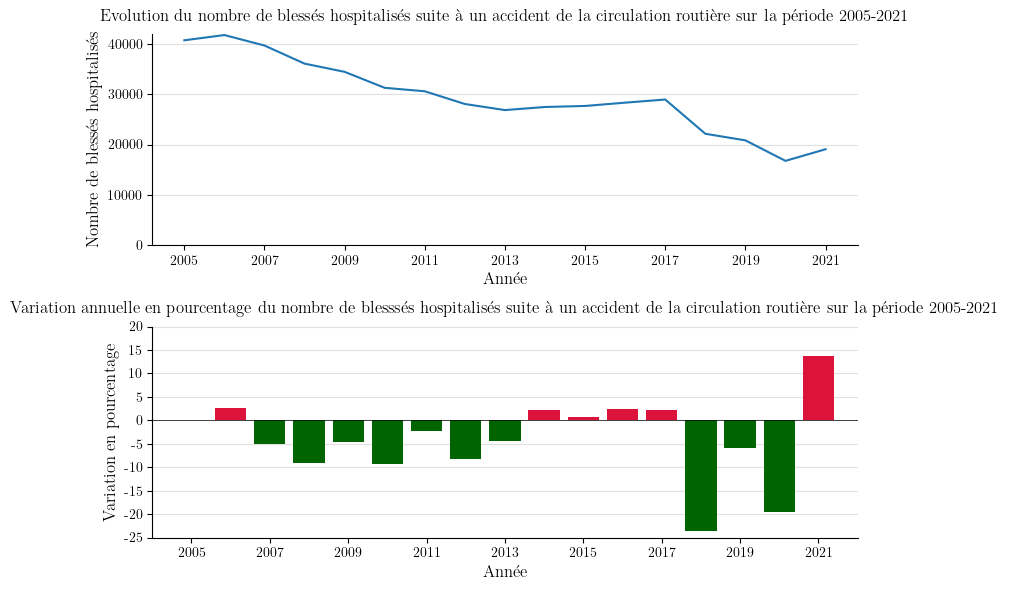

In [16]:
hosp_par_an = grav_par_an_long.loc[grav_par_an_long['grav']=='Hospitalisé']
hosp_par_an['var_pourc'] = hosp_par_an['Effectif'].pct_change()*100

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.plot(hosp_par_an['an'], hosp_par_an['Effectif'], color="tab:blue")
ax1.set_ylim(0,42000)
ax1.set_xticks([i for i in range(2005,2022,2)], [i for i in range(2005,2022,2)])
ax1.set_xlabel('Année', size=12)
ax1.set_ylabel("Nombre de blessés hospitalisés", size=12)
ax1.set_title("Evolution du nombre de blessés hospitalisés suite à un accident de la circulation routière sur la période 2005-2021", size=12, y=1.02)
ax1.grid(visible=True, axis='y', color="#e0e0e0")


couleurs = ["crimson" if hosp_par_an.iloc[i,3]>0 else "darkgreen" for i in range(len(hosp_par_an))]
ax2.bar(hosp_par_an['an'], hosp_par_an['var_pourc'], color=couleurs)
ax2.set_xlabel('Année', size=12)
ax2.set_xlim(2004,2022)
ax2.set_ylabel("Variation en pourcentage", size=12)
ax2.set_ylim(-20,20)
ax2.set_xticks([i for i in range(2005,2022,2)], [i for i in range(2005,2022,2)])
ax2.set_yticks([i for i in range(-25,25,5)], [i for i in range(-25,25,5)])
ax2.grid(visible=True, axis='y', color="#e0e0e0")
ax2.set_title("Variation annuelle en pourcentage du nombre de blesssés hospitalisés suite à un accident de la circulation routière sur la période 2005-2021", size=12, y=1.02)
ax2.set_axisbelow(True)
ax2.hlines(0,2004,2022, color='black', linewidth=0.5)

sns.despine()
plt.tight_layout()
plt.show()

In [17]:
df_var_pourc = pd.concat([acc_par_an.set_index('an')['var_pourc'], morts_par_an.set_index('an')['var_pourc'], hosp_par_an.set_index('an')['var_pourc']], axis=1, keys=['acc', 'morts', 'hosp'])
df_var_pourc = (df_var_pourc
                .stack()
                .reset_index(level=1)
                .rename(columns ={'level_1':'categorie', 0:'var_pourc'})
               )
df_var_pourc.head()

,categorie,var_pourc
an,,
2006,acc,-4.634247
2006,morts,-10.878586
2006,hosp,2.558881
2007,acc,1.032617
2007,morts,-2.105263


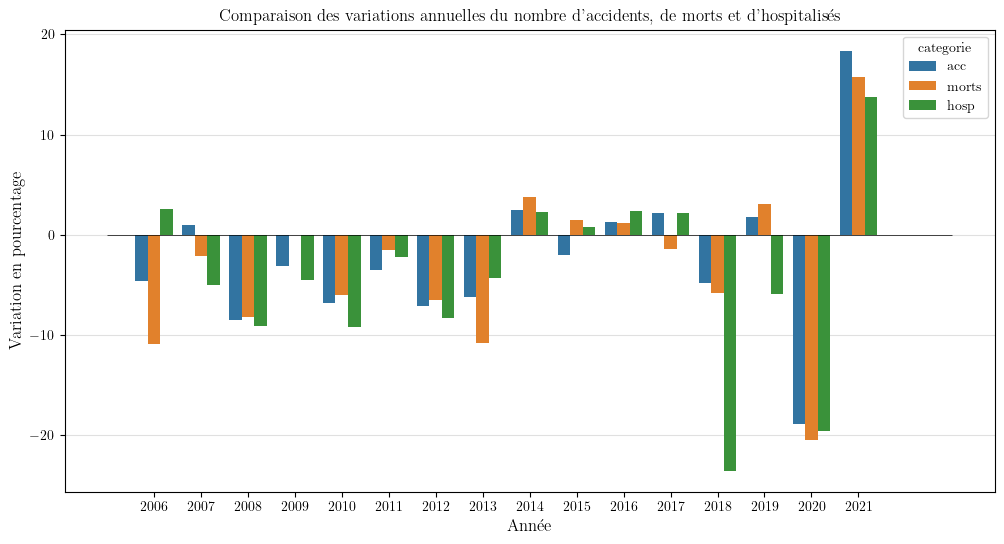

In [18]:
fig, ax = plt.subplots(figsize=(12,6))

sns.barplot(x='an', y='var_pourc', data=df_var_pourc.reset_index(), hue='categorie', ax=ax)
plt.hlines(0,-1,17, color='black', linewidth=0.5)
plt.title("Comparaison des variations annuelles du nombre d'accidents, de morts et d'hospitalisés", size=12)
plt.xlabel("Année", size=12)
plt.ylabel("Variation en pourcentage", size=12)
plt.grid(visible=True, axis='y', color="#e0e0e0")
ax.set_axisbelow(True)
plt.show()

Le nombre de blessés hospitalisés et le nombre de morts ont à peu près suivi la même évolution que le nombre d'accidents. On remarque néanmoins une nette différence en 2018 et 2019 entre la variation du nombre d'accidents et celle du nombre d'hospitalisés.


On peut vérifier s'il y a corrélation linéaire entre nombre de morts (resp. d'hospitalisés) et nombre d'accidents. Ce n'est pas a priori évident car les améliorations d'équipements de sécurité des véhicules ainsi que des aménagements routiers pourraient faire chuter le nombre de morts ou de blessés graves plus vite que le nombre d'accidents.

### 2.1.2. Y-a-t-il eu corélation entre nombre de morts (resp. de blessés hospitalisés) et le nombre d'accidents entre 2005 et 2021 ?

- **Corrélation nombre de morts/nombre d'accidents**

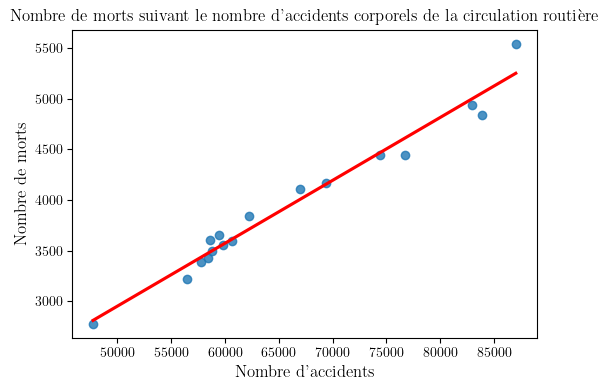

In [19]:
morts_vs_acc = pd.DataFrame(acc_par_an['Effectif']).rename(columns={'Effectif':'Accidents'})
morts_vs_acc['Morts'] = morts_par_an['Effectif'].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(6,4))

sns.regplot(x='Accidents', y='Morts', data=morts_vs_acc, ci=None, line_kws={'color':'red'})
plt.xlabel("Nombre d'accidents", size=12)
plt.ylabel("Nombre de morts", size=12)
plt.title("Nombre de morts suivant le nombre d'accidents corporels de la circulation routière", size=12)

plt.show()

Il semble y avoir une corrélation linéaire entre les deux variables. Regardons la normalité des deux variables.

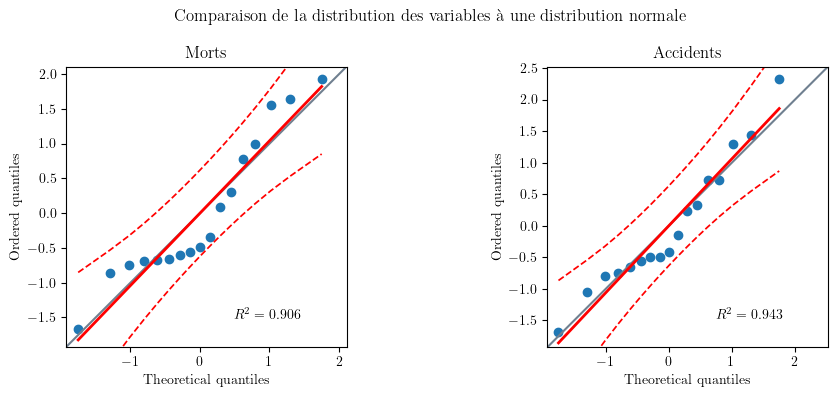

In [20]:
import pingouin

fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(10,4))
pingouin.qqplot(morts_vs_acc['Accidents'], dist='norm', color='tab:blue', ax=ax1)
ax1.set_title('Morts')
pingouin.qqplot(morts_vs_acc['Morts'], dist='norm', color='tab:blue', ax=ax2)
ax2.set_title('Accidents')
plt.suptitle('Comparaison de la distribution des variables à une distribution normale')
fig.tight_layout()
plt.show()

Les variables ne suivent pas une distribution normale. Nous allons faire un test de corrélation de Spearman :
- Hypothèse nulle $H_0$ : pas de corrélation entre les variables (coefficient de corrélation nul)
- Hypothèse alternative $H_1$ : corrélation positive (coefficient de corrélation positif et significativement différent de 0) -> test unilatéral
- Seuil de signification $\alpha=0,05$

In [21]:
pingouin.corr(morts_vs_acc['Morts'], morts_vs_acc['Accidents'], alternative='greater', method='spearman')

,n,r,CI95%,p-val,power
spearman,17,0.969957,"[0.93, 1.0]",6.438087e-11,1.0


Le test de Spearman indique que les deux variables sont significativement corrélées ($\small p<0.0001^{***}$). La corrélation est très forte : $\small\rho = 0,97$.

- **Corrélation nombre d'hospitalisés/nombre d'accidents**

In [22]:
# Dataframe hospitalisés vs accidents
hosp_vs_acc = pd.DataFrame(acc_par_an['Effectif']).rename(columns={'Effectif':'Accidents'})
hosp_vs_acc['Hospitalisés'] = hosp_par_an['Effectif'].reset_index(drop=True)

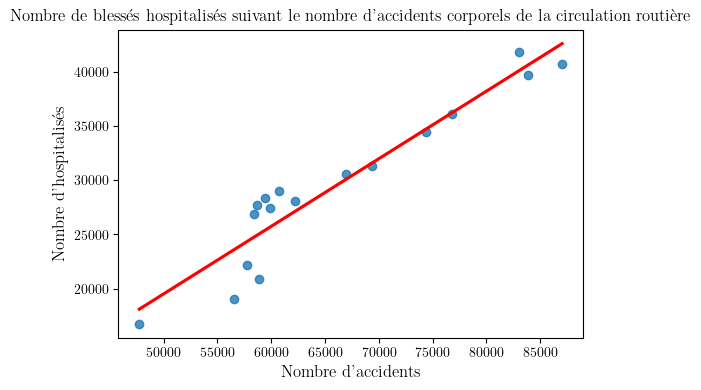

In [23]:
fig, ax = plt.subplots(figsize=(6,4))

sns.regplot(x=acc_par_an['Effectif'], y=hosp_par_an['Effectif'], ci=None, line_kws={'color':'red'})
plt.xlabel("Nombre d'accidents", size=12)
plt.ylabel("Nombre d'hospitalisés", size=12)
plt.title("Nombre de blessés hospitalisés suivant le nombre d'accidents corporels de la circulation routière", size=12)

plt.show()

Il semble y avoir une bonne corrélation positive entre les deux variables. On sait que le nombre d'accidents ne suit pas une distribution normale donc faisons un test de corrélation de Spearman :

- Hypothèse nulle $H_0$ : pas de corrélation entre les variables (coefficient de corrélation nul)
- Hypothèse alternative $H_1$ : corrélation positive (coefficient de corrélation positif et significativement différent de 0) -> test unilatéral
- Seuil de signification $\alpha=0,05$

In [24]:
pingouin.corr(hosp_vs_acc['Hospitalisés'], hosp_vs_acc['Accidents'], alternative='greater', method='spearman')

,n,r,CI95%,p-val,power
spearman,17,0.958333,"[0.9, 1.0]",7.234956e-10,1.0


Le test de Spearman indique que les deux variables sont significativement corrélées ($\small p<0.0001^{***}$). La corrélation est très forte : $\small\rho = 0,96$.

### 2.1.2. Les proportions de blessés légers, hospitalisés et morts restent-ils constants au fil des années ?

In [25]:
pourc_par_grav = gravite_par_an.divide(gravite_par_an.sum(axis=1), axis=0)*100
pourc_par_grav

grav,Indemne,Tué,Hospitalisé,Bléssé léger
an,,,,
2005,40.633510,2.811037,20.670734,35.884719
2006,40.696411,2.644327,22.376683,34.282579
2007,40.787838,2.569798,21.106777,35.535587
2008,40.700727,2.601359,21.162995,35.534919
2009,40.828592,2.679105,20.807714,35.684590
2010,40.739105,2.709144,20.328967,36.222784
2011,40.773579,2.768364,20.626975,35.831082
2012,40.794206,2.774448,20.283366,36.147980
2013,40.905061,2.664323,20.900084,35.530532


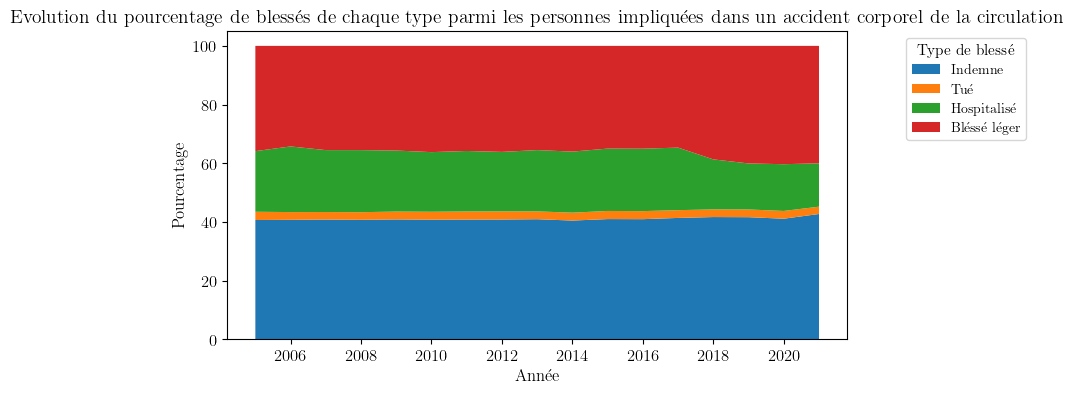

In [26]:
fig,ax = plt.subplots(figsize=(8,4))
plt.stackplot(pourc_par_grav.index, pourc_par_grav.transpose(), labels=pourc_par_grav.columns, cmap='tab10')

#Mise en forme des axes, titre et légende
plt.title('Evolution du pourcentage de blessés de chaque type parmi les personnes impliquées dans un accident corporel de la circulation', fontsize=14)
plt.xlabel('Année', fontsize=12)
plt.ylabel('Pourcentage', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Type de blessé', bbox_to_anchor=[1.3,1], fontsize=10, title_fontsize=11)
plt.show()

Les proportions restent à peu près les mêmes à part une baisse du pourcentage d'hospitalisés au profit du pourcentage de blessés légers entre 2017 et 2019.

## 2.2 Existe-t-il des mois plus accidentogènes que d'autres ?

### 2.2.1. Calcul du nombre moyen d'accidents pour chaque mois de l'année sur la période 2005-2017

L'année 2020 étabnt particulière avec des mois de confinement, elle est retirée de cette partie de l'étude.

In [27]:
# Nombre d'accidents par année et par mois
acc_par_mois = (df_caract.loc[df_caract['an']!=2020]
                .groupby(['an','mois'])
                .agg(Effectif = pd.NamedAgg('Num_Acc','count'))
                .reset_index())
acc_par_mois.head()

,an,mois,Effectif
0,2005,1,7125
1,2005,2,5568
2,2005,3,6569
3,2005,4,6618
4,2005,5,7832


In [28]:
acc_par_mois['Effectif'].describe()

count     192.000000
mean     5592.848958
std      1052.849076
min      3350.000000
25%      4832.000000
50%      5409.500000
75%      6234.250000
max      8469.000000
Name: Effectif, dtype: float64

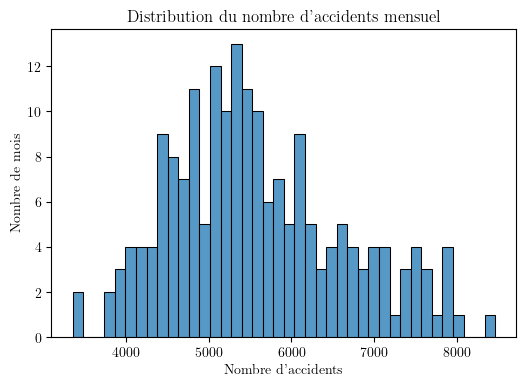

In [29]:
fig, ax= plt.subplots(figsize=(6,4))
sns.histplot(x='Effectif', data=acc_par_mois, bins=40)
plt.xlabel("Nombre d'accidents")
plt.ylabel("Nombre de mois")
plt.title("Distribution du nombre d'accidents mensuel")
plt.show()

In [30]:
# Moyenne par mois
moy_par_mois = (acc_par_mois
                .groupby('mois')
                .agg(moyenne = pd.NamedAgg('Effectif','mean'),
                     mediane = pd.NamedAgg('Effectif','median'),
                     variance = pd.NamedAgg('Effectif','var'),
                     std = pd.NamedAgg('Effectif','std'))
                .reset_index()
               )
moy_par_mois

,mois,moyenne,mediane,variance,std
0,1,5098.9375,4792.5,880131.262500,938.153113
1,2,4485.3750,4255.0,646608.383333,804.119632
2,3,5231.5000,5150.5,788831.466667,888.161847
3,4,5364.5000,5039.5,866269.600000,930.736053
4,5,5779.1875,5303.0,953666.295833,976.558393
5,6,6324.5625,5870.5,973471.062500,986.646372
6,7,5995.8125,5543.0,868710.962500,932.046653
7,8,5015.3750,4568.0,614245.050000,783.737871
8,9,6173.5000,5758.0,799352.933333,894.065397
9,10,6374.3125,5940.5,992176.362500,996.080500


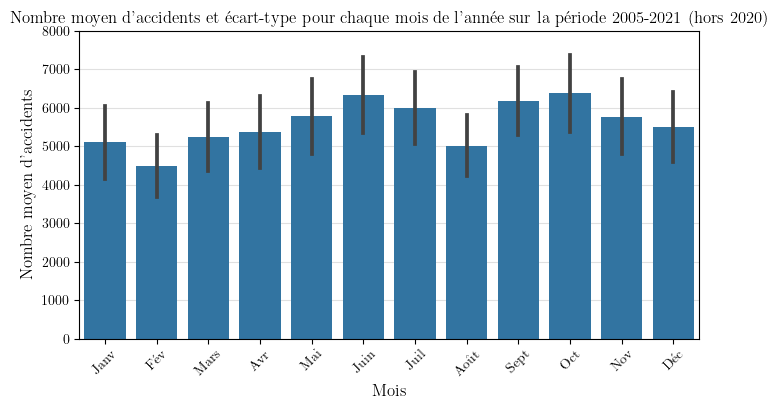

In [31]:
# Représentation graphique du nombre d'accidents moyen par mois de l'année

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(x='mois', y='Effectif', data= acc_par_mois, color='tab:blue', errorbar='sd')
plt.ylim(0,8000)
plt.xlabel('Mois', size=12)
plt.ylabel("Nombre moyen d'accidents", size=12)
plt.xticks([i for i in range(12)], ["Janv", "Fév", "Mars", "Avr", "Mai", "Juin", "Juil", "Août", "Sept", "Oct", "Nov", "Déc"], rotation=45)
plt.grid(visible=True, axis='y', color="#e0e0e0")
plt.title("Nombre moyen d'accidents et écart-type pour chaque mois de l'année sur la période 2005-2021 (hors 2020)", size=12)
ax.set_axisbelow(True)
plt.show()

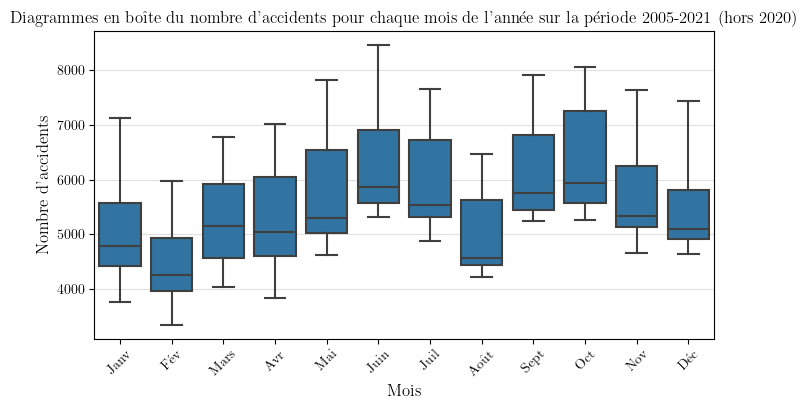

In [32]:
# boxplot du nombre d'accidents par mois de l'année

fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(x='mois', y='Effectif', data= acc_par_mois, color='tab:blue', whis=[0,100])
plt.xlabel('Mois', size=12)
plt.ylabel("Nombre d'accidents", size=12)
plt.xticks([i for i in range(12)], ["Janv", "Fév", "Mars", "Avr", "Mai", "Juin", "Juil", "Août", "Sept", "Oct", "Nov", "Déc"], rotation=45)
plt.grid(visible=True, axis='y', color="#e0e0e0")
plt.title("Diagrammes en boîte du nombre d'accidents pour chaque mois de l'année sur la période 2005-2021 (hors 2020)", size=12)
ax.set_axisbelow(True)
plt.show()

On remarque que les mois de juin, septembre et octobre ont été les plus accidentogènes, février étant le mois le moins accidentogène. Mais ces différence sont-elles significatives ? Pour répondre, nous pouvons voir s'il est possible de réaliser une ANOVA.

### 2.2.2. ANOVA

In [33]:
#Définition d'une fonction d'affichage de graphiques de diagnostics d'un modèle

def diagnostic_plots(fitted, resid, norm_resid, leverage, alpha=0.5):
    """Fonction qui affiche les graphiques de diagnostic d'un modèle:
    - residus vs valeurs prédites
    - qqplot résidus vs distribution normale
    - scale location
    - résidus vs effet de levier
    
    paramètres :
    - fitted : valeurs prédites
    - resid : résidus
    - norm_resid : résidus normalisés
    - leverage : effet de levier
    - alpha : opacité des points (défaut=0.5)
    """
    
    #racine carrée des résidus standardisés
    resid_sqrt = np.sqrt(np.abs(norm_resid))
    
    # Graphiques de diagnostic d'un
    fig,((ax00, ax01), (ax10,ax11)) = plt.subplots(2,2,figsize=(7,7))

    sns.regplot(x=fitted, y=resid, lowess=True, line_kws={'color':'red'}, scatter_kws={'alpha':alpha}, ax=ax00)
    ax00.set_title('Résidus en fonction des valeurs prédites', size=10)
    ax00.set_xlabel('Valeurs prédites')
    ax00.set_ylabel('Résidus')

    pingouin.qqplot(resid, dist='norm', color='tab:blue', ax=ax01)
    ax01.set_title('Q-Q plot de comparaison à une distribution normale', size=10)
    ax01.set_xlabel('Quantiles de la distribution normale')
    ax01.set_ylabel('Quantiles des résidus')

    sns.regplot(x=fitted, y=resid_sqrt, lowess=True, line_kws={'color':'red'}, scatter_kws={'alpha':alpha}, ax=ax10)
    ax10.set_title('Scale-location', size=10)
    ax10.set_xlabel('Valeurs prédites')
    ax10.set_ylabel('Racine carrée des résidus standardisés')

    sns.regplot(x=leverage, y=resid_sqrt, lowess=True, line_kws={'color':'red'}, scatter_kws={'alpha':alpha}, ax=ax11)
    ax11.set_title('Résidus vs effet de levier', size=10)
    ax11.set_xlabel('Effet de levier')
    ax11.set_ylabel('Résidus standardisés')

    plt.tight_layout()
    plt.show()


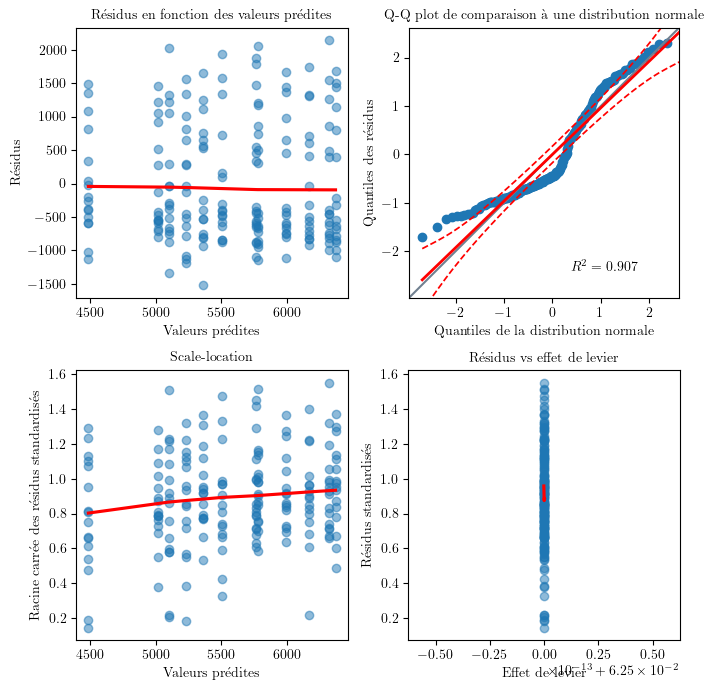

In [34]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model_lin_acc_mois = ols("Effectif ~ C(mois)", data=acc_par_mois).fit()


# Valeurs prédites
fitted_lm = model_lin_acc_mois.fittedvalues
# Résidus
residus_lm = model_lin_acc_mois.resid
#residus standardisés et leur racine carrée
influence_lm = model_lin_acc_mois.get_influence()
residus_norm_lm = influence_lm.resid_studentized_internal
#effet de levier
leverage_lm = influence_lm.hat_matrix_diag

# Graphiques de diagnostic
diagnostic_plots(fitted_lm, residus_lm, residus_norm_lm, leverage_lm)

On constate que les résidus ne suivent pas une distribution normale mais nous prendrons le parti qu'il sont suffisamment proches d'une distribution normale pour réaliser une ANOVA. 

ANOVA :

- Hypothèse nulle $\small H_0$ : le nombre moyen d'accidents est le même suivant le mois.
- Hypothèse alternative $\small H_1$ : le nombre moyen est différent suivant le mois.
- Seuil de signification : $\small\alpha=0.05$

In [35]:
anova_table = sm.stats.anova_lm(model_lin_acc_mois, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(mois),5.928142e+07,11.0,6.363534,7.298885e-09
Residual,1.524404e+08,180.0,NaN,NaN


L'ANOVA permet de rejeter l'hypothèse nulle au risque de 5% : $\small F(11,\,180)=6.37$, $\small p<0.0001^{***}$. On en conclut qu'il y a une différence significative du nombre moyen d'accidents suivant le mois.

### 2.2.3 Test de Kruskal-Wallis

Compte-tenu de la non normalité des résidus du modèle linéaire, un test non paramétrique de Kruskal-Wallis est plus adapté qu'une ANOVA.

- Hypothèse nulle $\small H_0$ : le nombre médian d'accidents est le même suivant le mois.
- Hypothèse alternative $\small H_1$ : le nombre médian est différent suivant le mois.
- Seuil de signification : $\small\alpha=0.05$

In [36]:
liste_groupes = []
# Pour chaque mois, on crée une liste du nombre d'accidents sur les années 2005-2021 (hors 2020)
for i in range(1,13):
    df = acc_par_mois.loc[acc_par_mois['mois']==i]
    liste_groupes.append(df['Effectif'].tolist())

In [37]:
from scipy import stats

stats.kruskal(liste_groupes[0], liste_groupes[1], liste_groupes[2],
             liste_groupes[3], liste_groupes[4], liste_groupes[5],
             liste_groupes[6], liste_groupes[7], liste_groupes[8],
             liste_groupes[9], liste_groupes[10], liste_groupes[11])

KruskalResult(statistic=56.59406297473406, pvalue=3.951928213444532e-08)

Le test de Kruskal-Wallis permet de rejeter l'hypothèse $\small H_0$ au risque de 5% : $\chi^2(11)=56.59, p<0.001^{***}$. Le nombre médian d'accidents est différent suivant le mois de l'année.

### 2.2.4. Comparaison multiple
Comparaisons multiples des mois deux à deux.

In [38]:
import statsmodels.stats.multicomp as multi

multicomp_mois = multi.MultiComparison(acc_par_mois['Effectif'], acc_par_mois['mois'])

# Effectuer le test post-hoc de Tukey
result = multicomp_mois.tukeyhsd()

# Afficher les résultats
print(result)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff  p-adj    lower      upper   reject
-----------------------------------------------------------
     1      2  -613.5625 0.7665  -1691.042   463.917  False
     1      3   132.5625    1.0   -944.917  1210.042  False
     1      4   265.5625 0.9996   -811.917  1343.042  False
     1      5     680.25   0.63  -397.2295 1757.7295  False
     1      6   1225.625 0.0117   148.1455 2303.1045   True
     1      7    896.875 0.2082  -180.6045 1974.3545  False
     1      8   -83.5625    1.0  -1161.042   993.917  False
     1      9  1074.5625 0.0513     -2.917  2152.042  False
     1     10   1275.375 0.0068   197.8955 2352.8545   True
     1     11    667.875 0.6567  -409.6045 1745.3545  False
     1     12    405.375 0.9843  -672.1045 1482.8545  False
     2      3    746.125 0.4853  -331.3545 1823.6045  False
     2      4    879.125  0.234  -198.3545 1956.6045  False
     2      5  1293.8125 0.0056    216.3

## 2.3. Y-a-t-il des mois plus meurtriers que d'autres ?
### 2.3.1. Calcul du nombre moyen de morts pour chaque mois de l'année sur la période 2005-2021

In [39]:
# Nombre de morts par année et par mois
morts_par_mois = (df_usagers.loc[df_usagers['grav']==2, ['Num_Acc']]
                  .merge(df_caract.loc[df_caract['an']!=2020, ['Num_Acc', 'an', 'mois']], how='inner', left_on='Num_Acc', right_on='Num_Acc')
                  .groupby(['an','mois'])
                  .agg(Effectif = pd.NamedAgg('Num_Acc','count'))
                  .reset_index()
                 )
morts_par_mois.head()

,an,mois,Effectif
0,2005,1,426
1,2005,2,368
2,2005,3,406
3,2005,4,389
4,2005,5,470


In [40]:
morts_par_mois['Effectif'].describe()

count    192.000000
mean     334.734375
std       70.436911
min      187.000000
25%      287.750000
50%      327.000000
75%      371.250000
max      631.000000
Name: Effectif, dtype: float64

335 morts par mois en moyenne sur la période 2005-2017 (hors année 2020)

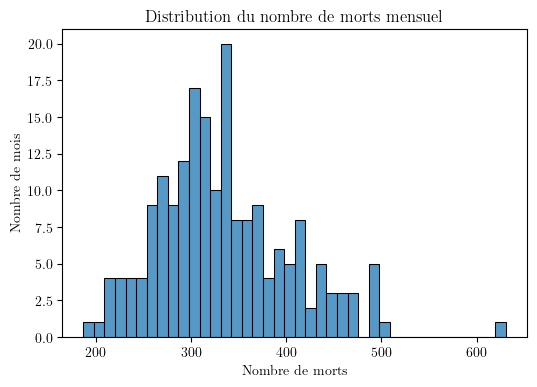

In [41]:
fig, ax= plt.subplots(figsize=(6,4))
sns.histplot(x='Effectif', data=morts_par_mois, bins=40)
plt.xlabel("Nombre de morts")
plt.ylabel("Nombre de mois")
plt.title("Distribution du nombre de morts mensuel")
plt.show()

On remarque un outlier. Regardons à quel mois il correspond.

In [42]:
morts_par_mois.loc[morts_par_mois['Effectif']==morts_par_mois['Effectif'].max()]

,an,mois,Effectif
6,2005,7,631


Il s'agit de juillet 2005. Après recherche sur internet, il n'apparaît pas de raison particulière.

In [43]:
# Moyenne par mois
moy_morts_mois = (morts_par_mois
                .groupby('mois')
                .agg(moyenne = pd.NamedAgg('Effectif','mean'),
                     mediane = pd.NamedAgg('Effectif','median'),
                     variance = pd.NamedAgg('Effectif','var'),
                     std = pd.NamedAgg('Effectif','std'))
                .reset_index()
               )
moy_morts_mois

,mois,moyenne,mediane,variance,std
0,1,298.6250,281.0,3896.116667,62.418881
1,2,265.1875,268.0,2095.762500,45.779499
2,3,294.1250,288.0,3036.516667,55.104598
3,4,309.0625,293.0,3473.662500,58.937785
4,5,328.6250,322.5,4596.783333,67.799582
5,6,347.2500,327.5,3212.466667,56.678626
6,7,407.3750,373.5,6393.450000,79.959052
7,8,362.3125,347.5,4225.962500,65.007403
8,9,356.1875,341.0,2954.295833,54.353434
9,10,370.3750,355.5,4270.783333,65.351231


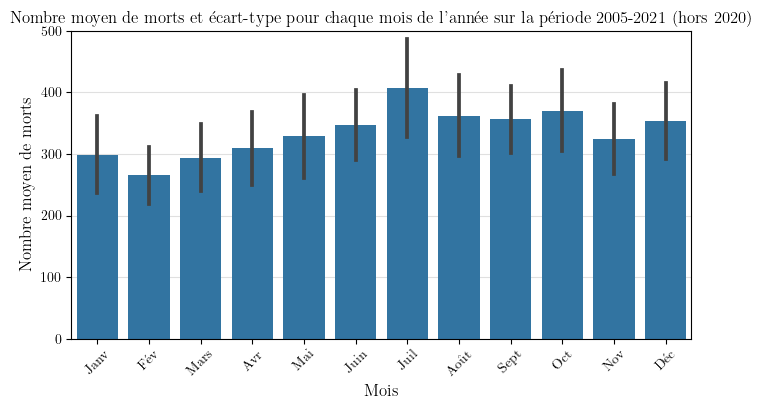

In [44]:
# Représentation graphique du nombre d'accidents moyen par mois de l'année

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(x='mois', y='Effectif', data= morts_par_mois, color='tab:blue', errorbar='sd')
plt.ylim(0,500)
plt.xlabel('Mois', size=12)
plt.ylabel("Nombre moyen de morts", size=12)
plt.xticks([i for i in range(12)], ["Janv", "Fév", "Mars", "Avr", "Mai", "Juin", "Juil", "Août", "Sept", "Oct", "Nov", "Déc"], rotation=45)
plt.grid(visible=True, axis='y', color="#e0e0e0")
plt.title("Nombre moyen de morts et écart-type pour chaque mois de l'année sur la période 2005-2021 (hors 2020)", size=12)
ax.set_axisbelow(True)
plt.show()

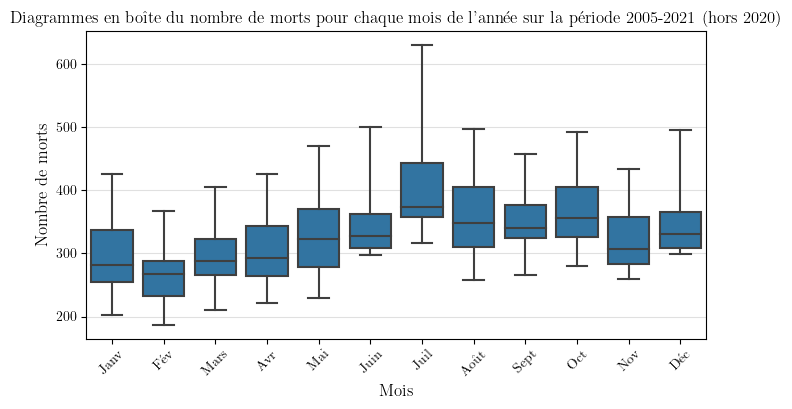

In [45]:
# boxplot du nombre de morts par mois de l'année

fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(x='mois', y='Effectif', data= morts_par_mois, color='tab:blue', whis=[0,100])
plt.xlabel('Mois', size=12)
plt.ylabel("Nombre de morts", size=12)
plt.xticks([i for i in range(12)], ["Janv", "Fév", "Mars", "Avr", "Mai", "Juin", "Juil", "Août", "Sept", "Oct", "Nov", "Déc"], rotation=45)
plt.grid(visible=True, axis='y', color="#e0e0e0")
plt.title("Diagrammes en boîte du nombre de morts pour chaque mois de l'année sur la période 2005-2021 (hors 2020)", size=12)
ax.set_axisbelow(True)
plt.show()

Résultats intéressants : 
- Alors que le mois de juillet ne se classe que 4ème en nombre moyen d'accidents, c'est le mois le plus meurtrier.
- Le mois d'août est un des mois avec le plus faible nombre moyen d'accidents mais un des plus hauts nombres moyens de morts.

Regardons si les différences observées entre mois sont significatives.

### 2.3.2 ANOVA

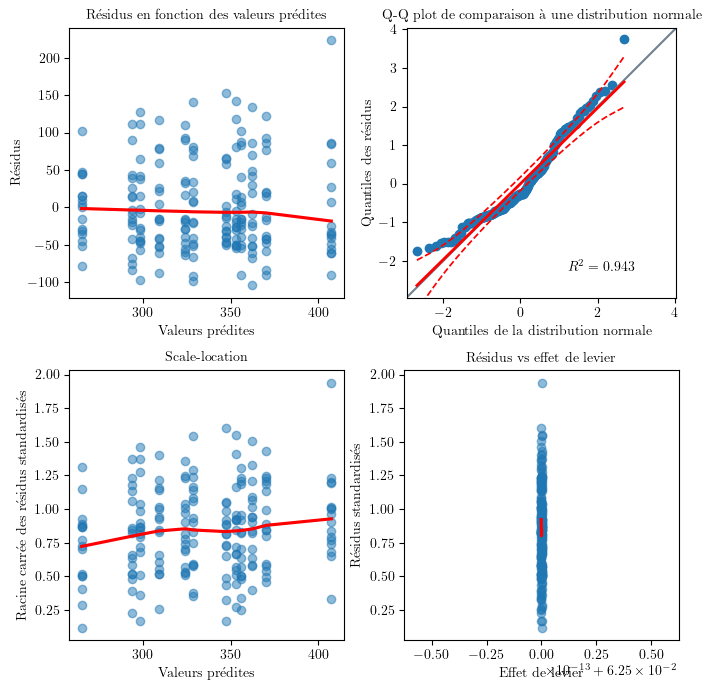

In [46]:
model_lin_morts_mois = ols("Effectif ~ C(mois)", data=morts_par_mois).fit()


# Valeurs prédites
fitted_lm = model_lin_morts_mois.fittedvalues
# Résidus
residus_lm = model_lin_morts_mois.resid
#residus standardisés et leur racine carrée
influence_lm = model_lin_morts_mois.get_influence()
residus_norm_lm = influence_lm.resid_studentized_internal
#effet de levier
leverage_lm = influence_lm.hat_matrix_diag

# Graphiques de diagnostic
diagnostic_plots(fitted_lm, residus_lm, residus_norm_lm, leverage_lm)

Là-encore, les résidus ne suivent pas une loi normale mais nous considérerons que nous pouvons faire une ANOVA :

- Hypothèse nulle $\small H_0$ : le nombre moyen de morts est le même suivant le mois.
- Hypothèse alternative $\small H_1$ : le nombre moyen est différent suivant le mois.
- Seuil de signification : $\small\alpha=0.05$

In [47]:
anova_table_morts = sm.stats.anova_lm(model_lin_morts_mois, typ=2)
anova_table_morts

,sum_sq,df,F,PR(>F)
C(mois),269865.265625,11.0,6.515603,4.308671e-09
Residual,677754.187500,180.0,NaN,NaN


L'ANOVA permet de rejeter l'hypothèse nulle au risque de 5% : $\small F(11,\,180)=6.52$, $\small p<0.0001^{***}$. On en conclut qu'il y a une différence significative du nombre moyen de morts suivant le mois.

### 2.3.3. Test de Kruskal-Wallis

- Hypothèse nulle $\small H_0$ : le nombre médian de morts est le même suivant le mois.
- Hypothèse alternative $\small H_1$ : le nombre médian est différent suivant le mois.
- Seuil de signification : $\small\alpha=0.05$

In [48]:
liste_groupes = []
# Pour chaque mois, on crée une liste du nombre de morts sur les années 2005-2021 (hors 2020)
for i in range(1,13):
    df = morts_par_mois.loc[morts_par_mois['mois']==i]
    liste_groupes.append(df['Effectif'].tolist())

In [49]:
from scipy import stats

stats.kruskal(liste_groupes[0], liste_groupes[1], liste_groupes[2],
             liste_groupes[3], liste_groupes[4], liste_groupes[5],
             liste_groupes[6], liste_groupes[7], liste_groupes[8],
             liste_groupes[9], liste_groupes[10], liste_groupes[11])

KruskalResult(statistic=57.45443794049504, pvalue=2.74375436692588e-08)

Le test de Kruskal-Wallis permet de rejeter l'hypothèse nulle au risque de 5% : $\small \chi^2(11) = 57.45, p<0.0001^{***}$. Le nombre médian de morts diffère suivant les mois de l'année.

### 2.3.4. Comparaisons multiples

In [50]:
multicomp_mois = multi.MultiComparison(morts_par_mois['Effectif'], morts_par_mois['mois'])

# Effectuer le test post-hoc de Tukey
result = multicomp_mois.tukeyhsd()

# Afficher les résultats
print(result)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
     1      2 -33.4375 0.9269 -105.2823  38.4073  False
     1      3     -4.5    1.0  -76.3448  67.3448  False
     1      4  10.4375    1.0  -61.4073  82.2823  False
     1      5     30.0 0.9655  -41.8448 101.8448  False
     1      6   48.625 0.5222  -23.2198 120.4698  False
     1      7   108.75 0.0001   36.9052 180.5948   True
     1      8  63.6875 0.1375   -8.1573 135.5323  False
     1      9  57.5625 0.2588  -14.2823 129.4073  False
     1     10    71.75 0.0506   -0.0948 143.5948  False
     1     11  25.6875 0.9896  -46.1573  97.5323  False
     1     12    54.75 0.3323  -17.0948 126.5948  False
     2      3  28.9375 0.9735  -42.9073 100.7823  False
     2      4   43.875 0.6776  -27.9698 115.7198  False
     2      5  63.4375 0.1414   -8.4073 135.2823  False
     2      6  82.0625 0.0111   10.2177 153.9073

## 2.4. Comparaison du taux de mortalité

Le fait que l'on observe des mois avec "peu d'accidents" et un grand nombre de morts pousse à calculer le taux de mortalité que nous définirons de la manière suivante :

**taux de mortalité = nombre de morts pour 100 accidents**

Nous utiliserons ce calcul plutôt que le pourcentage d'accidents mortels parmi les accidents corporels car il peut y avoir plusieurs morts lors d'un accident.

### 2.4.1. Calcul des taux de mortalité

In [51]:
#jointure acc_par_mois et morts_par_mois
acc_vs_morts_par_mois = (acc_par_mois
                         .rename(columns={'Effectif':'accidents'})
                         .merge(morts_par_mois.rename(columns={'Effectif':'morts'}), how='inner', on=['an','mois'])
                        )
acc_vs_morts_par_mois.head()

,an,mois,accidents,morts
0,2005,1,7125,426
1,2005,2,5568,368
2,2005,3,6569,406
3,2005,4,6618,389
4,2005,5,7832,470


In [52]:
# Calcul du taux de mortalité
acc_vs_morts_par_mois['tx_mort'] = acc_vs_morts_par_mois['morts']/acc_vs_morts_par_mois['accidents']*100
acc_vs_morts_par_mois.head()

,an,mois,accidents,morts,tx_mort
0,2005,1,7125,426,5.978947
1,2005,2,5568,368,6.609195
2,2005,3,6569,406,6.180545
3,2005,4,6618,389,5.877909
4,2005,5,7832,470,6.001021


In [53]:
# Taux de mortalité moyen pour chaque mois de l'année
(acc_vs_morts_par_mois
 .groupby('mois')
 .agg(taux_moyen = pd.NamedAgg('tx_mort','mean'),
      taux_median = pd.NamedAgg('tx_mort','median'),
      variance = pd.NamedAgg('tx_mort','var'),
      std = pd.NamedAgg('tx_mort','std'))
)

,taux_moyen,taux_median,variance,std
mois,,,,
1,5.843077,5.809016,0.168947,0.411032
2,5.940371,6.054802,0.304039,0.551398
3,5.619113,5.605510,0.161878,0.402340
4,5.755641,5.742661,0.107171,0.327369
5,5.663005,5.783013,0.187471,0.432979
6,5.498642,5.515094,0.121844,0.349062
7,6.777223,6.634188,0.260464,0.510357
8,7.215034,7.348224,0.294118,0.542327
9,5.775850,5.860158,0.158728,0.398407


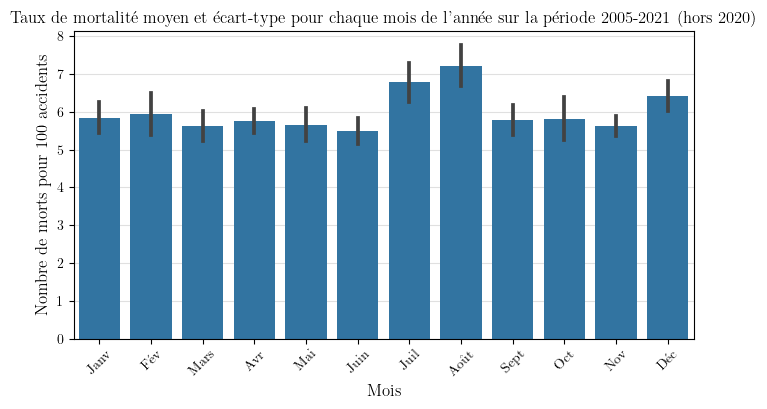

In [54]:
# Représentation graphique du taux de mortalité moyen par mois de l'année

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(x='mois', y='tx_mort', data= acc_vs_morts_par_mois, color='tab:blue', errorbar='sd')
plt.xlabel('Mois', size=12)
plt.ylabel("Nombre de morts pour 100 accidents", size=12)
plt.xticks([i for i in range(12)], ["Janv", "Fév", "Mars", "Avr", "Mai", "Juin", "Juil", "Août", "Sept", "Oct", "Nov", "Déc"], rotation=45)
plt.grid(visible=True, axis='y', color="#e0e0e0")
plt.title("Taux de mortalité moyen et écart-type pour chaque mois de l'année sur la période 2005-2021 (hors 2020)", size=12)
ax.set_axisbelow(True)
plt.show()

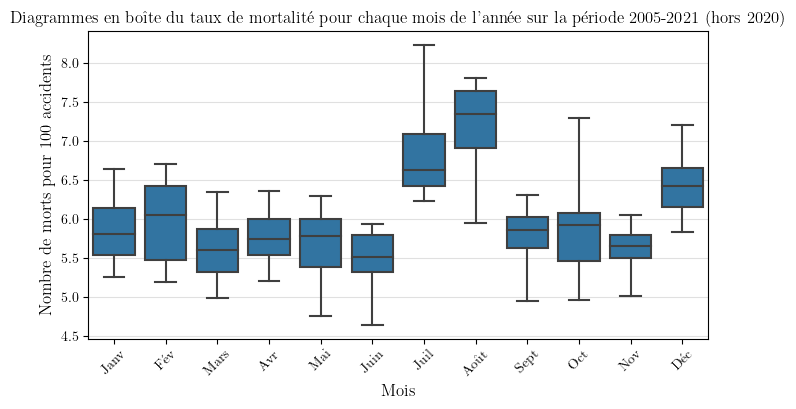

In [55]:
# boxplot du taux de mortalité par mois de l'année

fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(x='mois', y='tx_mort', data= acc_vs_morts_par_mois, color='tab:blue', whis=[0,100])
plt.xlabel('Mois', size=12)
plt.ylabel("Nombre de morts pour 100 accidents", size=12)
plt.xticks([i for i in range(12)], ["Janv", "Fév", "Mars", "Avr", "Mai", "Juin", "Juil", "Août", "Sept", "Oct", "Nov", "Déc"], rotation=45)
plt.grid(visible=True, axis='y', color="#e0e0e0")
plt.title("Diagrammes en boîte du taux de mortalité pour chaque mois de l'année sur la période 2005-2021 (hors 2020)", size=12)
ax.set_axisbelow(True)
plt.show()

On voit clairement trois mois avec des taux de mortalité supérieurs aux autres : juillet, août et décembre. On peut avancer les hyptohèses des départs en vacances. Testons si les différences observées sont significatives.

### 2.4.2. ANOVA

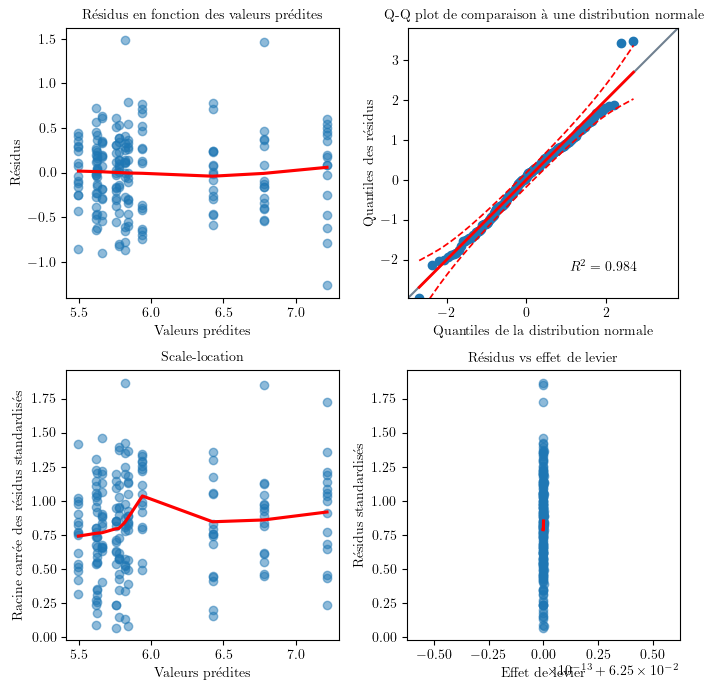

In [56]:
model_lin_tx_mort = ols("tx_mort ~ C(mois)", data=acc_vs_morts_par_mois).fit()


# Valeurs prédites
fitted_lm = model_lin_tx_mort.fittedvalues
# Résidus
residus_lm = model_lin_tx_mort.resid
#residus standardisés et leur racine carrée
influence_lm = model_lin_tx_mort.get_influence()
residus_norm_lm = influence_lm.resid_studentized_internal
#effet de levier
leverage_lm = influence_lm.hat_matrix_diag

# Graphiques de diagnostic
diagnostic_plots(fitted_lm, residus_lm, residus_norm_lm, leverage_lm)

Mis à part deux résidus, les résidus suivent approximativement une loi normale et l'homoscédasticité est relativement bonne. Nous considèrerons que nous sommes dans des conditions valides d'utilisation d'une ANOVA

- Hypothèse nulle $\small H_0$ : le taux de mortalité est le même suivant le mois.
- Hypothèse alternative $\small H_1$ : le taux de mortalité est différent suivant le mois.
- Seuil de signification : $\small\alpha=0.05$

In [57]:
anova_tx_mort = sm.stats.anova_lm(model_lin_tx_mort, typ=2)
anova_tx_mort

,sum_sq,df,F,PR(>F)
C(mois),49.344079,11.0,23.177844,4.165712e-29
Residual,34.837087,180.0,NaN,NaN


L'ANOVA permet de rejeter l'hypothèse nulle : $\small F(11, 180) = 23.18, p<0.000^{***}$. On en déduit qu'il y a une différence significative entre les taux de mortalités des différents mois de l'année. Le text de Tuckey devrait nous montrer qu'il y a une déifférence significative entre les mois de juillet, août et décembre d'un côté, et les autres mois de l'autre côté.

### 2.4.3. Test de Tuckey

In [58]:
multicomp_mois = multi.MultiComparison(acc_vs_morts_par_mois['tx_mort'], acc_vs_morts_par_mois['mois'])

# Effectuer le test post-hoc de Tukey
result = multicomp_mois.tukeyhsd()

# Afficher les résultats
print(result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   0.0973    1.0 -0.4178  0.6124  False
     1      3   -0.224 0.9539 -0.7391  0.2911  False
     1      4  -0.0874    1.0 -0.6025  0.4277  False
     1      5  -0.1801 0.9913 -0.6952   0.335  False
     1      6  -0.3444 0.5415 -0.8595  0.1707  False
     1      7   0.9341    0.0  0.4191  1.4492   True
     1      8    1.372    0.0  0.8569   1.887   True
     1      9  -0.0672    1.0 -0.5823  0.4479  False
     1     10  -0.0258    1.0 -0.5409  0.4893  False
     1     11  -0.2194 0.9602 -0.7345  0.2957  False
     1     12    0.582 0.0128  0.0669  1.0971   True
     2      3  -0.3213 0.6478 -0.8363  0.1938  False
     2      4  -0.1847 0.9893 -0.6998  0.3304  False
     2      5  -0.2774  0.825 -0.7925  0.2377  False
     2      6  -0.4417 0.1726 -0.9568  0.0734  False
     2      7   0.8369    0.0  0.3218  1.3519 

- Le taux de mortalité de juillet est significativement différent de celui de tous les autres mois de l'année à l'exception de août et décembre ($\small p<0.0001^{***}$ à chaque fois)
- Le taux de mortalité d'août est significativement différent de celui de tous les autres mois de l'année à l'exception de juillet uniquement ($\small p<0.0001^{***}$ à chaque fois)
- Le taux de mortalité de décembre est significativement différent de celui de tous les autres mois de l'année à l'exception de juillet, août et février.

## 2.5. Taux de mortalité suivant le jour de la semaine.

### 2.5.1 Calcul du taux de mortalité chaque jour

Les taux de mortalité élevés aux mois de juillet, août et décembre amènent à se poser la question de leur cause. Une hyptohèse est un taux de mortalité élevé lors des week-ends de départ en vacances. Mais il faut aussi regarder les taux de mortalités le week-end les autres mois. En effet, si on observe une élévation du taux de mortalité le week-end en juillet et août mais également les autres mois, celà ne permettra pas de conclure en l'influence des week-ends de départ en vacances.

Pour étudier ces taux, il faut créer une variable date et y faire correspondre le jour de la semaine.



In [59]:
# Création de la variable date
df_caract['date'] = pd.to_datetime(df_caract[['an','mois','jour']].rename(columns={'an':'year', 'mois':'month', 'jour':'day'}))
df_caract[['an','mois','jour','date']].head()

,an,mois,jour,date
0,2019,11,30,2019-11-30
1,2019,11,30,2019-11-30
2,2019,11,28,2019-11-28
3,2019,11,30,2019-11-30
4,2019,11,30,2019-11-30


In [89]:
# Création du jour de la semaine
df_caract['nom_jour'] = df_caract['date'].dt.day_name(locale='fr_FR.utf8')
df_caract['nom_mois'] = df_caract['date'].dt.month_name(locale='fr_FR.utf8')
df_caract[['an','mois','jour','date','nom_jour', 'nom_mois']].head()

,an,mois,jour,date,nom_jour,nom_mois
0,2019,11,30,2019-11-30,Samedi,Novembre
1,2019,11,30,2019-11-30,Samedi,Novembre
2,2019,11,28,2019-11-28,Jeudi,Novembre
3,2019,11,30,2019-11-30,Samedi,Novembre
4,2019,11,30,2019-11-30,Samedi,Novembre


In [92]:
acc_par_jour = (df_caract
                .groupby(['an','mois','nom_mois','nom_jour'])
                .agg(accidents = pd.NamedAgg('Num_Acc','count'))
                .reset_index()
                )
acc_par_jour.head()

,an,mois,nom_mois,nom_jour,accidents
0,2005,1,Janvier,Dimanche,763
1,2005,1,Janvier,Jeudi,992
2,2005,1,Janvier,Lundi,1127
3,2005,1,Janvier,Mardi,1021
4,2005,1,Janvier,Mercredi,1070


In [93]:
morts_par_jour = (df_caract[['Num_Acc','an','mois','jour','date','nom_jour']]
                  .merge(df_usagers.loc[df_usagers['grav']==2], on='Num_Acc', how='inner')
                  .groupby(['an','mois','nom_jour'])
                  .agg(morts = pd.NamedAgg('Num_Acc','count'))
                  .reset_index()
                 )
morts_par_jour.head()

,an,mois,nom_jour,morts
0,2005,1,Dimanche,76
1,2005,1,Jeudi,41
2,2005,1,Lundi,49
3,2005,1,Mardi,57
4,2005,1,Mercredi,54


Nous pouvons maintenant étudier le taux de mortalité pour chaque jour de la semaine et pour chaque mois de l'année.

In [95]:
acc_vs_morts_par_jour = acc_par_jour.merge(morts_par_jour, on=['an','mois','nom_jour'], how='inner')
acc_vs_morts_par_jour['tx_mortalite'] = acc_vs_morts_par_jour['morts']/acc_vs_morts_par_jour['accidents']*100
acc_vs_morts_par_jour.head()

,an,mois,nom_mois,nom_jour,accidents,morts,tx_mortalite
0,2005,1,Janvier,Dimanche,763,76,9.960682
1,2005,1,Janvier,Jeudi,992,41,4.133065
2,2005,1,Janvier,Lundi,1127,49,4.347826
3,2005,1,Janvier,Mardi,1021,57,5.582762
4,2005,1,Janvier,Mercredi,1070,54,5.046729


In [116]:
acc_vs_morts_pivot = round(acc_vs_morts_par_jour.pivot_table(index='mois', columns='nom_jour', values='tx_mortalite', aggfunc='mean'), 1)
acc_vs_morts_pivot

nom_jour,Dimanche,Jeudi,Lundi,Mardi,Mercredi,Samedi,Vendredi
mois,,,,,,,
1,8.8,4.9,5.1,5.4,5.3,7.1,5.4
2,7.9,5.2,5.4,5.2,4.9,7.5,5.7
3,8.7,4.7,4.6,5.0,4.5,7.4,5.5
4,8.9,5.3,5.7,4.8,4.5,7.5,5.5
5,8.2,5.3,5.7,4.2,4.9,6.9,5.4
6,7.7,4.8,5.1,4.4,5.0,6.9,5.0
7,8.7,6.0,5.9,5.8,6.1,8.0,6.8
8,9.5,6.3,6.6,6.3,6.3,8.2,6.7
9,8.2,4.9,5.1,5.0,4.8,7.4,5.5


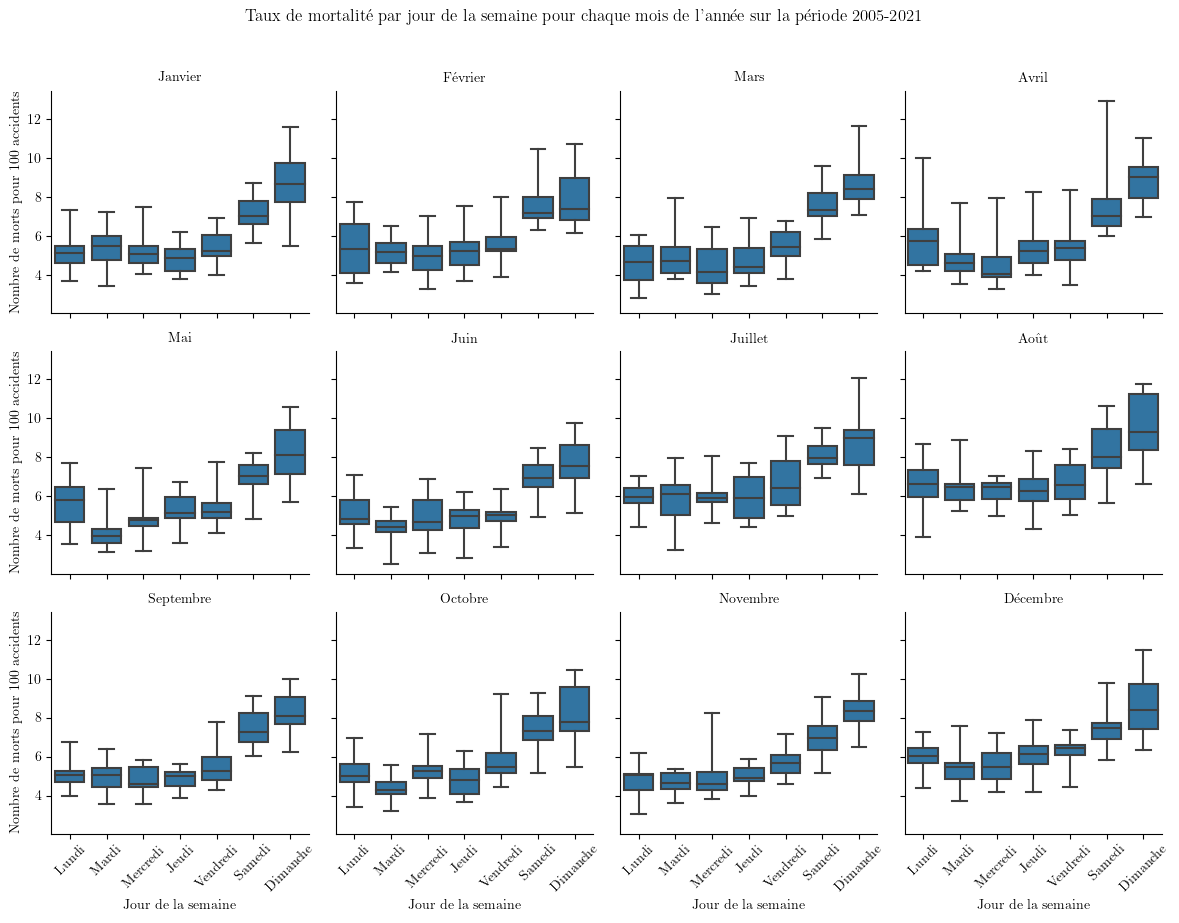

In [108]:
ordre_jours = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']

g = sns.catplot(x='nom_jour', y='tx_mortalite', data=acc_vs_morts_par_jour, 
                kind='box', order=ordre_jours, whis=[0,100], color='tab:blue',
                col='nom_mois', col_wrap=4,
                height=3, aspect=1)

plt.xlabel('Jour de la semaine')
plt.ylabel('Nombre de morts pour 100 accidents')
plt.suptitle("Taux de mortalité par jour de la semaine pour chaque mois de l'année sur la période 2005-2021", size=12, y=1.02)
g.set_titles('{col_name}',size=10)
g.set_xlabels("Jour de la semaine", size=10)
g.set_xticklabels(['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'], rotation=45)
g.set_ylabels("Nombre de morts pour 100 accidents",size=10)
g.fig.subplots_adjust(hspace = 1)
plt.tight_layout()
plt.show()

Quel que soit le mois, le taux de mortalité augmente le week-end. Quel différence y-a-t-il entre le taux de mortalité moyen le week-end et en semaine pour chaque mois ?

### 2.5.2 Comparaison des taux de mortalités en semaine et le week-end pous chaque mois de l'année.

In [110]:
tx_mort_we = (acc_vs_morts_par_jour
              .loc[acc_vs_morts_par_jour['nom_jour'].isin(['Samedi', 'Dimanche'])]
              .groupby(['mois','nom_mois'])
              .agg(tx_mort_we = pd.NamedAgg('tx_mortalite','mean'))
              .reset_index()
             )comp_tx_mort_sem_we
tx_mort_we

,mois,nom_mois,tx_mort_we
0,1,Janvier,7.934478
1,2,Février,7.715609
2,3,Mars,8.057820
3,4,Avril,8.194144
4,5,Mai,7.552664
5,6,Juin,7.292802
6,7,Juillet,8.382621
7,8,Août,8.878838
8,9,Septembre,7.828066
9,10,Octobre,7.787255


In [112]:
tx_mort_sem = (acc_vs_morts_par_jour
              .loc[~acc_vs_morts_par_jour['nom_jour'].isin(['Samedi', 'Dimanche'])]
              .groupby(['mois','nom_mois'])
              .agg(tx_mort_sem = pd.NamedAgg('tx_mortalite','mean'))
              .reset_index()
             )
tx_mort_sem

,mois,nom_mois,tx_mort_sem
0,1,Janvier,5.237393
1,2,Février,5.299147
2,3,Mars,4.849437
3,4,Avril,5.168544
4,5,Mai,5.095289
5,6,Juin,4.864405
6,7,Juillet,6.112726
7,8,Août,6.452162
8,9,Septembre,5.043194
9,10,Octobre,5.069290


In [114]:
comp_tx_mort_we_sem = tx_mort_we.merge(tx_mort_sem, on=['mois','nom_mois'])
comp_tx_mort_we_sem['diff'] = comp_tx_mort_we_sem['tx_mort_we']-comp_tx_mort_we_sem['tx_mort_sem']
comp_tx_mort_we_sem

,mois,nom_mois,tx_mort_we,tx_mort_sem,diff
0,1,Janvier,7.934478,5.237393,2.697085
1,2,Février,7.715609,5.299147,2.416462
2,3,Mars,8.057820,4.849437,3.208383
3,4,Avril,8.194144,5.168544,3.025599
4,5,Mai,7.552664,5.095289,2.457375
5,6,Juin,7.292802,4.864405,2.428398
6,7,Juillet,8.382621,6.112726,2.269895
7,8,Août,8.878838,6.452162,2.426676
8,9,Septembre,7.828066,5.043194,2.784872
9,10,Octobre,7.787255,5.069290,2.717965


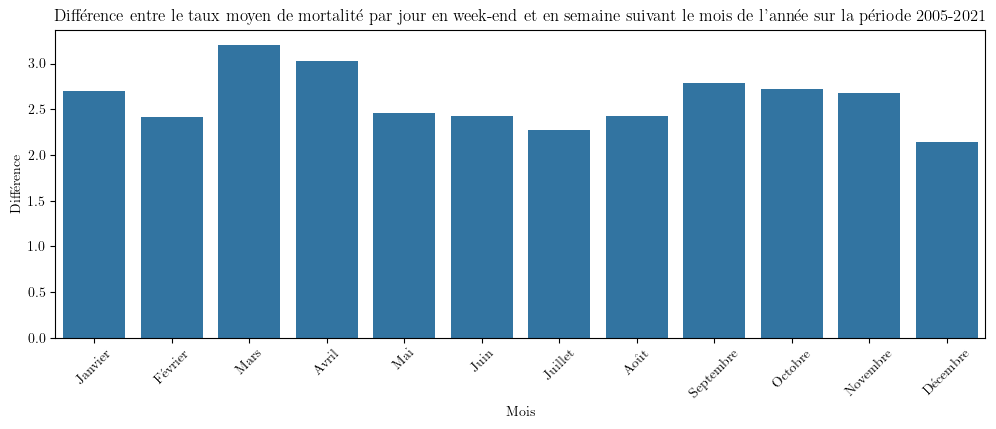

In [127]:
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(x='nom_mois', y='diff', data=comp_tx_mort_we_sem, color='tab:blue', ax=ax)
plt.title("Différence entre le taux de mortalité moyen par jour en week-end et en semaine suivant le mois de l'année sur la période 2005-2021", size=12)
plt.xlabel('Mois')
plt.ylabel('Différence')
plt.xticks(rotation=45)
plt.show()

On n'observe pas une différence supérieure en juillet et août concernant du taux de mortalité entre le week-end et la semaine. Le taux de mortalité supérieur de ces deux mois ne s'explique donc pas par les accidents des week-ends de départ en vacance. Le taux est supérieur sur l'ensemble de la semaine.